In [47]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, Subset
from datasets import ImageNet1k, get_imagenet_subsets, ZCAWhitening, ConeTransform
from utils import get_MMD_at_every_layer

import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Seed
SEED = 12
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0")

root_dir = "/data/datasets/ImageNet2012/"
train_dir = os.path.join(root_dir, "train")
val_dir = os.path.join(root_dir, "val")

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

transform_cone = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ConeTransform(),
])

start_layer = 1
num_layers = None
batch_size = 200

In [48]:
dataset1, dataset2, dataset3, dataset4 = get_imagenet_subsets(train_dir, num_classes=10, imgs_per_subset=1000, transform=transform, selected_classes=None)

In [49]:
dataloader1 = DataLoader(dataset1, batch_size=batch_size, shuffle=True)
dataloader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=True)
dataloader3 = DataLoader(dataset3, batch_size=batch_size, shuffle=True)
dataloader4 = DataLoader(dataset4, batch_size=batch_size, shuffle=True)

In [50]:
model_random = models.resnet18(weights=None)
model_random = model_random.to(device)

In [ ]:
Baseline_setting1 = get_MMD_at_every_layer(model_random, dataloader1, dataloader2, device, start_layer=start_layer, num_layers= num_layers)
Baseline_setting2 = get_MMD_at_every_layer(model_random, dataloader3, dataloader4, device, start_layer=start_layer, num_layers= num_layers)
torch.cuda.empty_cache()

In [39]:
model_ZCA = models.resnet18(weights=None)
state_dict = torch.load("conv1_data_based_init/r20_kmeans_init_5000img_1.pth")
model_ZCA.load_state_dict(state_dict)

<All keys matched successfully>

In [40]:
ZCA_init_setting1 = get_MMD_at_every_layer(model_ZCA, dataloader1, dataloader2, device, start_layer=start_layer, num_layers=num_layers)
ZCA_init_setting2 = get_MMD_at_every_layer(model_ZCA, dataloader3, dataloader4, device, start_layer=start_layer, num_layers=num_layers)

In [41]:
dataset1.dataset.transform = transform_cone
dataloader1 = DataLoader(dataset1, batch_size=batch_size, shuffle=True)
dataloader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=True)
dataloader3 = DataLoader(dataset3, batch_size=batch_size, shuffle=True)
dataloader4 = DataLoader(dataset4, batch_size=batch_size, shuffle=True)

In [42]:
LMS_Cone_setting1 = get_MMD_at_every_layer(model_random, dataloader1, dataloader2, device, start_layer=start_layer, num_layers=num_layers)
LMS_Cone_setting2 = get_MMD_at_every_layer(model_random, dataloader3, dataloader4, device, start_layer=start_layer, num_layers=num_layers)
torch.cuda.empty_cache() 

In [43]:
LMS_Cone_ZCA_setting1 = get_MMD_at_every_layer(model_ZCA, dataloader1, dataloader2, device, start_layer=start_layer, num_layers=num_layers)
LMS_Cone_ZCA_setting2 = get_MMD_at_every_layer(model_ZCA, dataloader3, dataloader4, device, start_layer=start_layer, num_layers=num_layers)
torch.cuda.empty_cache() 

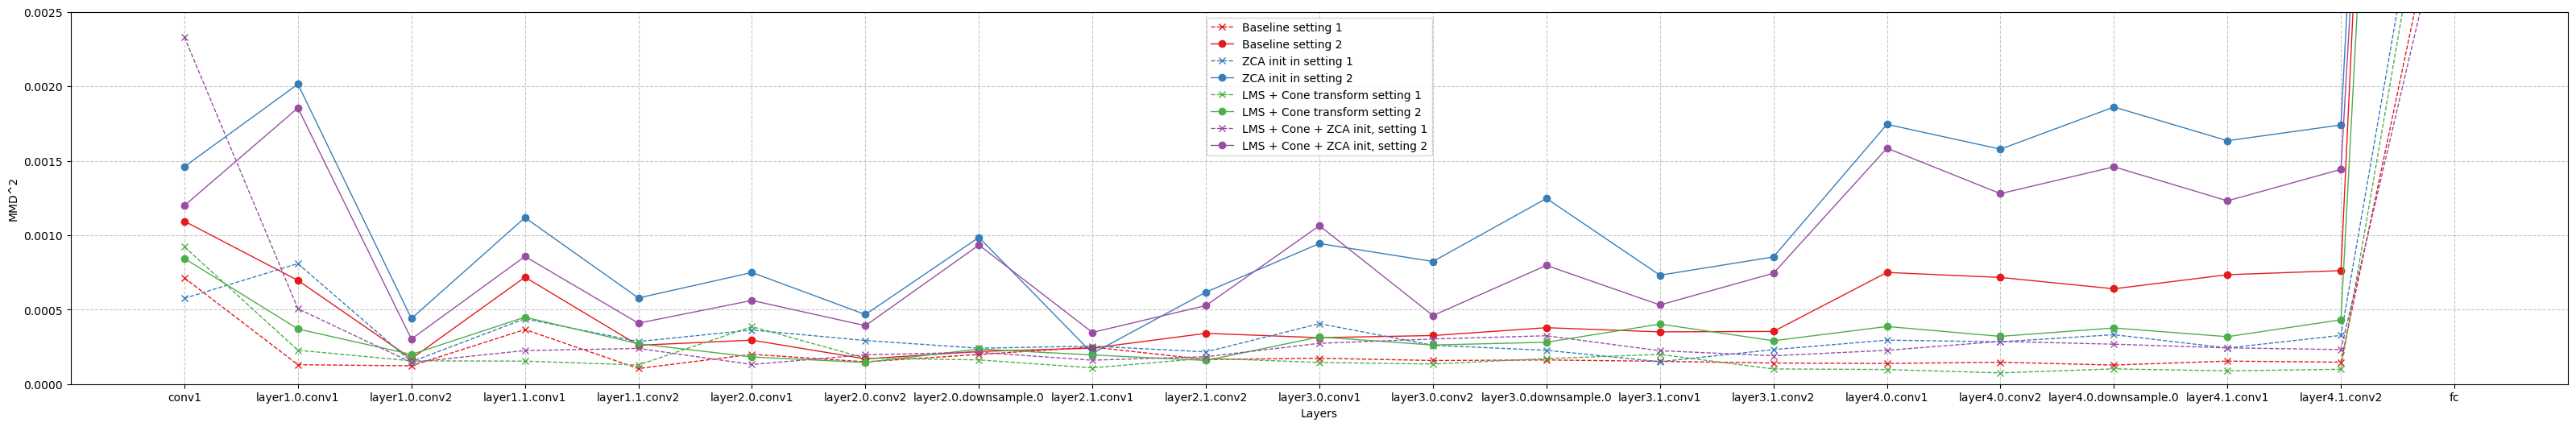

In [44]:
colors = sns.color_palette("Set1")  # You can change "Set1" to other ColorBrewer palettes like "Dark2", "Paired", etc.
x_labels = Baseline_setting1.keys()
x_positions = range(len(x_labels))
line_width=1
plt.figure(figsize=(40, 6))
plt.grid(True, linestyle='--', alpha=0.7)

plt.plot(Baseline_setting1.values(), label="Baseline setting 1", color=colors[0], linestyle='--', marker='x', linewidth=line_width)
plt.plot(Baseline_setting2.values(), label="Baseline setting 2", color=colors[0], linestyle='-', marker='o', linewidth=line_width)
plt.plot(ZCA_init_setting1.values(), label="ZCA init in setting 1", color=colors[1], linestyle='--', marker='x', linewidth=line_width)
plt.plot(ZCA_init_setting2.values(), label="ZCA init in setting 2", color=colors[1], linestyle='-', marker='o', linewidth=line_width)
plt.plot(LMS_Cone_setting1.values(), label="LMS + Cone transform setting 1", color=colors[2], linestyle='--', marker='x', linewidth=line_width)
plt.plot(LMS_Cone_setting2.values(), label="LMS + Cone transform setting 2", color=colors[2], linestyle='-', marker='o', linewidth=line_width)
plt.plot(LMS_Cone_ZCA_setting1.values(), label="LMS + Cone + ZCA init, setting 1", color=colors[3], linestyle='--', marker='x', linewidth=line_width)
plt.plot(LMS_Cone_ZCA_setting2.values(), label="LMS + Cone + ZCA init, setting 2", color=colors[3], linestyle='-', marker='o', linewidth=line_width)

plt.xlabel('Layers')
plt.ylabel('MMD^2')
plt.ylim(0, 0.0025)
plt.xticks(x_positions, x_labels)
plt.legend()
plt.savefig("mmd_on_imagenet")